In [1]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

%matplotlib inline



c:\Users\britneyspears\anaconda3\envs\fastai\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import string

punc_dict = {p: " "+p+" " for p in string.punctuation}

punc_translation = str.maketrans(punc_dict)


In [3]:
sentences = open("brown.txt").readlines()

In [4]:
def separate_punctuation(sentences):
    ret = [''] * len(sentences)
    for i, sentence in enumerate(sentences):
        translated_sentence = sentence.translate(punc_translation)
        ret[i]=translated_sentence
    
    return ret

def build_words(sentences):
    words_dict = {}
    for sentence in sentences:
        for w in sentence.split(" "):
            if w == '':
                continue
            words_dict[w] = words_dict.get(w, 0) + 1
    return words_dict

def get_words(words_dict):
    return words_dict.keys()

def map_rare_words(sentences, words_dict, freq_thresh=3, symbol="<UNK>"):
    ret = [''] * len(sentences)
    for i, sentence in enumerate(sentences):
        w = sentence.split(" ")
        for j, word in enumerate(w):
            if word == "":
                continue
            count = words_dict[word]
            if count <= 3:
                w[j] = symbol

        ret[i] = " ".join(w) 
    return ret 

def filter_empty_str (s):
    return list(filter(lambda ch:  ch != '' , s.split(" ")))

In [5]:
sentences_transformed = separate_punctuation(sentences)
word_dict = build_words(sentences_transformed)
words = get_words(word_dict)
sentences_transformed = map_rare_words(sentences_transformed, word_dict)
word_dict2 = build_words(sentences_transformed)
words2 = get_words(word_dict2)

In [6]:
print(f"words with punctuation {len(words):,.0f}")
print(f"words with punctuation and rare symbol {len(words2):,.0f}")
print(f"sentences {len(sentences_transformed):,.0f}")

words with punctuation 51,103
words with punctuation and rare symbol 17,797
sentences 19,810


In [7]:
# build the vocabulary of characters and mappings to/from integers
stoi = {s:i for i,s in enumerate(set(words2))}
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(vocab_size)

17797


In [54]:
import torch
# build the dataset
block_size = 5 # context length: how many characters do we take to predict the next one?

def build_dataset(sentences):  
    X, Y = [], []
  
    for sentence in sentences:
        words = filter_empty_str(sentence)
        context = [stoi[w] for w in words[:block_size] ]
        for word in words[block_size:] :
            if word == '':
                continue
            ix = stoi[word]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(sentences_transformed)
n1 = int(len(sentences_transformed) *0.8)
n2 = int(len(sentences_transformed) * 0.9) 

Xtr,  Ytr  = build_dataset(sentences_transformed[:n1])     
Xdev, Ydev = build_dataset(sentences_transformed[n1:n2])   
Xte,  Yte  = build_dataset(sentences_transformed[n2:])    

torch.Size([925041, 5]) torch.Size([925041])
torch.Size([123760, 5]) torch.Size([123760])
torch.Size([116581, 5]) torch.Size([116581])


In [55]:
print(Xtr[0])
print(Ytr[0])

print(list(map(lambda x: itos[x.item()], Xtr[0])))
print(itos[Ytr[0].item()])

tensor([12333,  6999,  6934, 10848, 13566])
tensor(12333)
['"', 'We', '-', 'we', '<UNK>']
"


In [56]:
from torch import nn
class MLP(nn.Module):
    def __init__(self, vocab_size, n_size=5, h_size=50, emb_size=60):
        super(MLP, self).__init__()
        self.C = nn.Embedding(vocab_size, emb_size).type(torch.float32)
        self.H = nn.Parameter(torch.randn((n_size)*emb_size, h_size).type(torch.float32))
        nn.init.kaiming_uniform_(self.H, mode='fan_in', nonlinearity='tanh')
        self.d = nn.Parameter(torch.randn(h_size).type(torch.float32))
        self.W = nn.Parameter(torch.randn((n_size)*emb_size, vocab_size).type(torch.float32)*0.01)
        self.U = nn.Parameter(torch.randn(h_size, vocab_size).type(torch.float32) * 0.01)
        self.b = nn.Parameter(torch.randn(vocab_size).type(torch.float32))
    def forward(self, x):
        x = self.C(x)
        x = x.view(x.shape[0],-1)
        tanh = torch.tanh(x @ self.H + self.d)
        x = tanh @ self.U + x @ self.W  + self.b
        return x

In [65]:
model = MLP(vocab_size)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

torch.Size([20, 50])


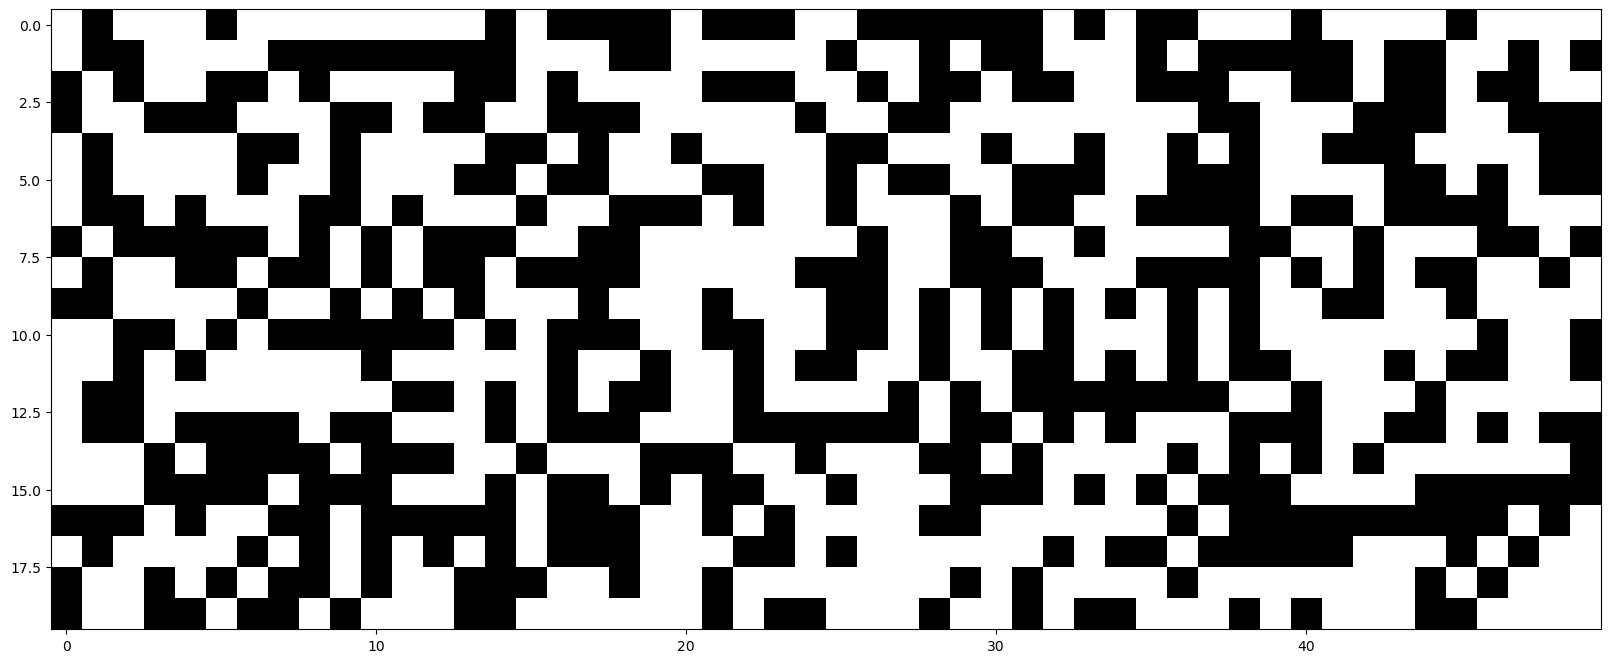

In [58]:
model.cpu()
h = torch.tanh(model.C(Xtr).view(Xtr.shape[0], -1) @ model.H + model.d)
t = h[:20,:].abs() > 0.99
print(t.shape)
plt.figure(figsize=(20,60))
plt.imshow(t, cmap="gray", interpolation="nearest")


In [66]:
max_steps = 100000
batch_size = 32
lossi = []
model.cuda()


for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    optimizer.zero_grad()
    logits = model(Xtr[ix].cuda())
    loss = loss_fn(logits, Ytr[ix].cuda())
    loss.backward()
    optimizer.step()
    optimizer.param_groups[0]['lr'] /=  1 + 10**-8 * i
    lossi.append(loss.item())
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

      0/ 100000: 10.4553
  10000/ 100000: 5.2829
  20000/ 100000: 4.4102
  30000/ 100000: 5.2758
  40000/ 100000: 4.9285
  50000/ 100000: 5.3346
  60000/ 100000: 5.5865
  70000/ 100000: 5.5749
  80000/ 100000: 6.1442
  90000/ 100000: 6.0310


In [64]:
lr1 = 0.001

for i in range(100000):
    lr1 /= 1 + 10**-8 * i 
    if i % 10000 == 0:
        print(lr1)

0.001
0.0006065104433717649
0.00013533979403683333
1.111232923719139e-05
3.3575343001773213e-07
3.7334899255612045e-09
1.528030657429031e-11
2.3020517996148116e-14
1.2767545923808674e-17
2.6070685044431836e-21
